In [51]:
import pandas as pd
from io import StringIO #문자열을 파일처럼 다루게 해주는 모듈
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

#행 3개 / 열 4개


# 파이썬 2.7을 사용하는 경우
# 다음과 같이 문자열을 유니코드로 변환해야 합니다:
if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data)) #csv 파일 만들기가 귀찮으니까 stringIO로 ..
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [52]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [53]:
# `values` 속성으로 넘파이 배열을 얻을 수 있습니다
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [54]:
# 누락된 값이 있는 행을 삭제합니다
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [55]:
# 누락된 값이 있는 열을 삭제합니다
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [56]:
# 모든 열이 NaN인 행을 삭제합니다
df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [57]:
# NaN 아닌 값이 네 개보다 작은 행을 삭제합니다
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [58]:
# 특정 열에 NaN이 있는 행만 삭제합니다(여기서는 'C'열)
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [59]:
# 행의 평균으로 누락된 값 대체하기
from sklearn.impute import SimpleImputer #누락된 값 대체 모듈
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [60]:
from sklearn.preprocessing import FunctionTransformer

ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

In [61]:

imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

In [62]:
#추가된 indicator_ 속성은 MissingIndicator 클래스의 객체입니다.
imr.indicator_

MissingIndicator(error_on_new=False)

In [63]:
#MissingIndicator 객체의 features_ 속성은 누락된 값이 있는 특성의 인덱스를 담고 있습니다.
imr.indicator_.features_

array([2, 3], dtype=int64)

In [64]:
#MissingIndicator 객체의 fit_transform() 메서드를 호출하면
#features_ 속성에 담긴 특성에서 누락된 값의 위치를 나타내는 배열을 반환합니다.
#여기에서는 세 번째, 네 번째 특성의 누락된 값의 위치입니다.
# 이 배열의 값이 SimpleImputer 객체의 transfrom() 메서드가 반환한 배열의 마지막 두 열에 해당합니다.
imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [65]:
# 사이킷런 0.24 버전에서 추가되었습니다.
imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [66]:
"""SimpleImputer는 한 특성의 통곗값을 사용하여 누락된 값을 채웁니다.
이와 달리 IterativeImputer 클래스는 다른 특성을 사용하여 누락된 값을 예측합니다.

먼저 initial_strategy 매개변수에 지정된 방식으로 누락된 값을 초기화합니다.
그다음 누락된 값이 있는 한 특성을 타깃으로 삼고 다른 특성을 사용해 모델을 훈련하여 예측합니다.
이런 식으로 누락된 값이 있는 모든 특성을 순회합니다.

initial_strategy 매개변수에 지정할 수 있는 값은 SimpleImputer와 동일하게 'mean', 'median', 'most_frequent', 'constant'가 가능합니다.

예측할 특성을 선택하는 순서는 누락된 값이 가장 적은 특성부터 선택하는 'ascending',
누락된 값이 가장 큰 특성부터 선택하는 'descending',
왼쪽에서 오른쪽으로 선택하는 'roman', 오른쪽에서 왼쪽으로 선택하는 'arabic', 랜덤하게 고르는 'random'이 있습니다.
기본값은 'ascending'입니다.

특성 예측은 종료 조건을 만족할 때까지 반복합니다.
각 반복 단계에서 이전 단계와 절댓값 차이 중 가장 큰 값이 누락된 값을 제외하고 가장 큰 절댓값에 tol 매개변수를 곱한 것보다 작을 경우 종료합니다.
tol 매개변수 기본값은 1e-3입니다.

또는 max_iter 매개변수에서 지정한 횟수에 도달할 때 종료합니다. max_iter의 기본값은 10입니다.
예측에 사용하는 모델은 estimator 매개변수에서 지정할 수 있으며 기본적으로 BayesianRidge 클래스를 사용합니다.
예측에 사용할 특성 개수는 n_nearest_features에서 지정할 수 있으며 상관 계수가 높은 특성을 우선하여 랜덤하게 선택합니다.
기본값은 None으로 모든 특성을 사용합니다."""

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iimr = IterativeImputer()
iimr.fit_transform(df.values)


array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.00047063,  8.        ],
       [10.        , 11.        , 12.        , 12.99964527]])

In [67]:
#KNNImputer 클래스는 K-최근접 이웃 방법을 사용해 누락된 값을 채웁니다. 
# 최근접 이웃의 개수는 n_neighbors 매개변수로 지정하며 기본값은 5입니다.
# 샘플 개수가 n_neighbors 보다 작으면 SimpleImputer(strategy='mean')과 결과가 같습니다.

from sklearn.impute import KNNImputer

kimr = KNNImputer()
kimr.fit_transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [68]:
df.fillna(df.mean()) #위와 비교

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [69]:
"""fillna() 메서드의 method 매개변수를 사용하여 누락된 값을 채울 수도 있습니다.
bfill 또는 backfill은 누락된 값을 다음 행의 값으로 채웁니다.
ffill 또는 pad는 누락된 값을 이전 행의 값으로 채웁니다."""


'fillna() 메서드의 method 매개변수를 사용하여 누락된 값을 채울 수도 있습니다.\nbfill 또는 backfill은 누락된 값을 다음 행의 값으로 채웁니다.\nffill 또는 pad는 누락된 값을 이전 행의 값으로 채웁니다.'

In [70]:
df.fillna(method='bfill') # method='backfill'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [71]:
df.fillna(method='ffill') # method='pad'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


In [72]:
df.fillna(method='ffill', axis=1)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0


In [73]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [74]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [75]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

In [76]:

import numpy as np

# 클래스 레이블을 문자열에서 정수로 바꾸기 위해
# 매핑 딕셔너리를 만듭니다
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [77]:
# 클래스 레이블을 문자열에서 정수로 바꿉니다
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [78]:
# 클래스 레이블을 거꾸로 매핑합니다
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [79]:
from sklearn.preprocessing import LabelEncoder

# 사이킷런의 LabelEncoder을 사용한 레이블 인코딩
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [80]:

# 거꾸로 매핑
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

In [81]:
class_le.classes_


array(['class1', 'class2'], dtype=object)

In [82]:

X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

In [84]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

In [85]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [93]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [96]:
c_transf.named_transformers_['onehot'].categories_
#reverse

[array(['blue', 'green', 'red'], dtype=object)]

In [97]:
#OneHotEncoder의 dtype 매개변수
# np.int로 지정하여 정수로 원-핫 인코딩합니다.

c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(dtype=int), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[0, 1, 0, 1, 10.1],
       [0, 0, 1, 2, 13.5],
       [1, 0, 0, 3, 15.3]], dtype=object)

In [98]:

# 원-핫 인코딩 via 판다스
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [99]:
#column 매개변수를 사용하여 변환하려는 특성을 구체적으로 지정할 수 있습니다.
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


In [100]:

# get_dummies에서 다중 공선성 문제 처리
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [101]:

# OneHotEncoder에서 다중 공선성 문제 처리
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[1.0, 0.0, 1, 10.1],
       [0.0, 1.0, 2, 13.5],
       [0.0, 0.0, 3, 15.3]], dtype=object)

In [102]:
"""추가 내용: 순서가 있는 특성 인코딩
순서가 있는 특성의 범주 사이에서 수치적 크기에 대해 확신이 없거나
두 범주 사이의 순서를 정의할 수 없다면 임곗값을 사용해
0/1로 인코딩할 수 있습니다.

예를 들어 M, L, XL 값을 가진 특성 size를 2개의 새로운 특성
"x > M"와 "x > L"로 나눌 수 있습니다."""
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [103]:
df['x > M'] = df['size'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['size'].apply(lambda x: 1 if x == 'XL' else 0)

del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


In [104]:

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신러닝 저장소의 Wine 데이터셋에 접근되지 않을 때
# 다음 코드의 주석을 제거하고 로컬 경로에서 데이터셋을 읽으세요:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [105]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [106]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

"""[0, 1]로 정규화, (sample - minimum) / (maximum - minimum)"""

In [107]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
"""표준화, (sample - mean) / 표준편차"""

In [108]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('표준화:', (ex - ex.mean()) / ex.std())

# 판다스는 기본적으로 ddof=1를 사용합니다(샘플 표준 편차).
# 반면 넘파이 std 메서드와 StandardScaler는 ddof=0를 사용합니다.

# 정규화합니다
print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화: [0.  0.2 0.4 0.6 0.8 1. ]


In [111]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)
"""box 퍼센트 그림을 생각하면 쉬움,
RobustScaler는 중간값(q2) 값을 빼고
1사분위(q1)와 3사분위(q3)의 차이로 나누어 데이터의 스케일을 조정합니다.

"""

In [112]:

(ex - np.percentile(ex, 50)) / (np.percentile(ex, 75) - np.percentile(ex, 25))

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [113]:
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train_maxabs = mas.fit_transform(X_train)
X_test_maxabs = mas.transform(X_test)

""""MaxAbsScaler는 각 특성별로 데이터를 최대 절댓값으로 나눕니다.
따라서 각 특성의 최댓값은 1이 됩니다.
전체 특성은 [-1, 1] 범위로 변경됩니다."""

In [114]:
#MaxAbsScaler
ex / np.max(np.abs(ex))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler에 대응하는 scale(), minmax_scale(), robust_scale(), maxabs_scale() 함수가 있습니다. 이 함수들은 1차원 배열도 입력 받을 수 있습니다.

In [115]:
from sklearn.preprocessing import scale, minmax_scale, robust_scale, maxabs_scale
print('StandardScaler:', scale(ex))
print('MinMaxScaler:', minmax_scale(ex))
print('RobustScaler:', robust_scale(ex))
print('MaxAbsScaler:', maxabs_scale(ex))

StandardScaler: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
MinMaxScaler: [0.  0.2 0.4 0.6 0.8 1. ]
RobustScaler: [-1.  -0.6 -0.2  0.2  0.6  1. ]
MaxAbsScaler: [0.  0.2 0.4 0.6 0.8 1. ]


MaxAbsScaler, maxabs_scaler()는 데이터를 중앙에 맞추지 않기 때문에 희소 행렬을 사용할 수 있습니다.

In [116]:

from scipy import sparse
X_train_sparse = sparse.csr_matrix(X_train)

X_train_maxabs = mas.fit_transform(X_train_sparse)


RobustScaler는 희소 행렬을 사용해 훈련할 수 없지만 변환은 가능합니다.

In [117]:

X_train_robust = rbs.transform(X_train_sparse)


마지막으로 Normalizer 클래스와 normalize() 함수는 특성이 아니라 샘플별로 정규화를 수행합니다. 또한 희소 행렬도 처리할 수 있습니다. 기본적으로 샘플의 L2 노름이 1이 되도록 정규화합니다.

In [118]:

from sklearn.preprocessing import Normalizer

nrm = Normalizer()
X_train_l2 = nrm.fit_transform(X_train)

L2 노름은 루트에 제곱들 더한 것

L1 노름은 절댓값을 취해서 더한 것

In [119]:
ex_2f = np.vstack((ex[1:], ex[1:]**2))
ex_2f

array([[ 1,  2,  3,  4,  5],
       [ 1,  4,  9, 16, 25]])

먼저 샘플 별로 특성의 제곱을 더하기 위해 axis=1을 사용합니다.
이 값의 제곱근을 구하면 L2 노름입니다.
그 다음 각 샘플의 특성을 해당 L2 노름으로 나눕니다.

In [120]:
l2_norm = np.sqrt(np.sum(ex_2f ** 2, axis=1))
print(l2_norm)
ex_2f / l2_norm.reshape(-1, 1)

#axis 행
#** 2 = 제곱

[ 7.41619849 31.28897569]


array([[0.13483997, 0.26967994, 0.40451992, 0.53935989, 0.67419986],
       [0.03196014, 0.12784055, 0.28764125, 0.51136222, 0.79900347]])

norm='l1'으로 지정하면 절댓값인 L1 노름을 사용합니다.
앞에서와 마찬가지로 샘플 별로 L1 노름을 계산한 다음 각 샘플을 나눕니다.

In [122]:

l1_norm = np.sum(np.abs(ex_2f), axis=1)
print(l1_norm)
ex_2f / l1_norm.reshape(-1, 1)

[15 55]


array([[0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333],
       [0.01818182, 0.07272727, 0.16363636, 0.29090909, 0.45454545]])

In [123]:
#norm='max'로 지정하면 각 샘플의 최대 절댓값을 사용하여 나눕니다.

max_norm = np.max(np.abs(ex_2f), axis=1)
print(max_norm)
ex_2f / max_norm.reshape(-1, 1)

[ 5 25]


array([[0.2 , 0.4 , 0.6 , 0.8 , 1.  ],
       [0.04, 0.16, 0.36, 0.64, 1.  ]])

L2 규제는 원형 그래프,
L1 규제는 마름모 꼴 그래프를 머릿속에 기억해두자

사이킷런에서 L1 규제를 지원하는 모델은 penalty 매개변수를 l1으로 지정하여 희소한 모델을 만들 수 있습니다:

In [124]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1', solver='liblinear')

#LogiticRegression 클래스의 Solver 중
#lbfgs, newtion-cg, sag => L2 Regularization만 제공
#saga, liblinear는 L1, L2 Regularization 둘 다 제공 그러므로 liblinear 사용

#l1만 있을 경우, 희소한 모델을 만들 수 있다.
"""희소한 모델? : 특정 특성들이 없는, 소수의 특성이 Dominating한 데이터 형태에 유용"""


LogisticRegression(penalty='l1', solver='liblinear')

In [125]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=1)
# C=1.0이 기본입니다.
# 규제 효과를 높이거나 낮추려면 C 값을 증가시키거나 감소시킵니다.
# C의 증가 = 규제 효과 감소
# C의 감소 = 규제 효과 증가
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

훈련 정확도: 1.0
테스트 정확도: 1.0


In [126]:
lr.intercept_
#마름모꼴에서의 어떤 절편? offset을 의미
#3개의 클래스를 나뉘는 기준이 다음과 같다.

array([-1.26392152, -1.21596534, -2.37040177])

In [127]:
lr.coef_[lr.coef_!=0].shape
#왜 23개인가?
#각 클래스를 나누는 특성들의 기준 값이 23개
#13개의 특성이 있고, 3개의 클래스가 있으니
#39개가 정상이지만? 실제로는 23개의 특성만 쓰였다고 표시하는 것

(23,)

In [128]:
lr.coef_
#실제는 더 많음. 많은 특성치가 0으로 처리된 것을 알 수 있다.

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

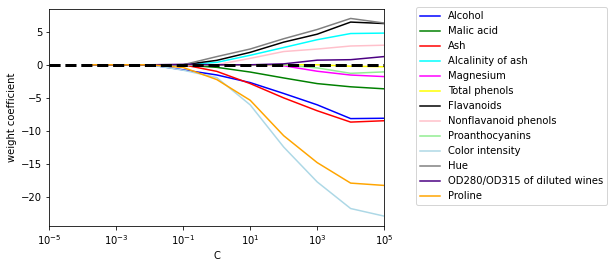

In [129]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.): #10^-4 ~ 10^6 까지 C를 반복, 즉 규제를 바꿔가면서 체크
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('images/04_07.png', dpi=300, 
#             bbox_inches='tight', pad_inches=0.2)
plt.show()

처음에 규제가 너무 강할 때 (C가 너무 작을 때) 모든 특성치가 0으로 수렴..

이 특성을 선택하는 순차 선택 알고리즘에 앞서서..

전진 선택 : 성능이 가장 좋은 특성 하나씩, 하나씩, 골라서, 최상의 결과만 선택해서 특성들을 추가하는 방식

후진 선택 : 전체 특성 사용 후, 하나 제거 했을 때 성능 손실이 제일 적은 특성을 제거, 또 하나 제거 등 이를 반복하여 선택

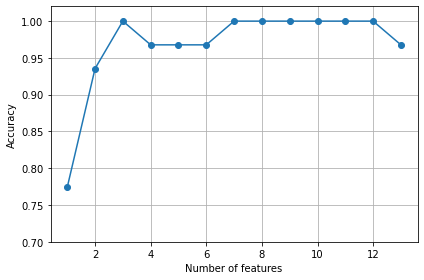

In [130]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            #이 while문이 상당히 중요하다.
            scores = []
            subsets = []
            #아래 for문은 조합을 만드는 행위를 반복한다. 전체 중에 dim-1을 고르는 조합을 만들어 특성을 하나씩 제거한다.
            #best를 통해 성능을 계속 측정
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택합니다
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 선택한 특성의 성능을 출력합니다
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [131]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

#knn의 최소 단위인 3(k3)으로 했을 때 가장 성능을 내는 특성은?

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [132]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))


훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [133]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


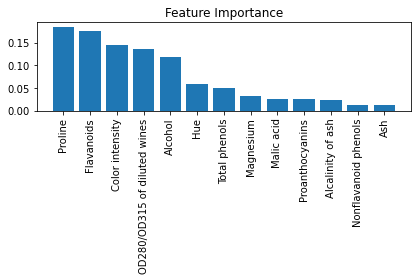

In [134]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('images/04_09.png', dpi=300)
plt.show()

랜덤포레스트는 특성중요도를 알아서 계산

Permutution_importances << 해당 함수가 더 잘 나온다고 언급

https://hong-yp-ml-records.tistory.com/51

In [136]:

from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
#중요도 0.1 이상의 특성 골라내기
#prefit 매개변수는 이미 앞에서 훈련을 했기 때문에 True로 전달
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 특성의 수:', 
      X_selected.shape[1])

이 임계 조건을 만족하는 특성의 수: 5


In [138]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


RFE(Recursive Featrue Elimination)

RFE는 재귀적 특성 제거 방법을 사용합니다. 처음에 모든 특성을 사용해 모델을 만들고 특성 중요도가 가장 낮은 특성을 제거합니다. 그다음 제외된 특성을 빼고 나머지 특성으로 새로운 모델을 만듭니다. 이런 식으로 미리 정의한 특성 개수가 남을 때까지 계속합니다.

RFE 클래스의 n_features_to_select 매개변수에 선택할 특성의 개수를 지정합니다. 사이킷런 0.24 버전부터 [0, 1] 범위의 실수를 지정하여 선택할 특성의 비율을 지정할 수도 있습니다. 기본값은 입력 특성 개수의 절반입니다.

step 매개변수에서 각 반복에서 제거할 특성의 개수를 지정합니다. (0, 1) 사이의 값을 지정하면 삭제할 특성의 비율이 됩니다. 기본값은 1입니다.

기본적으로 기반 모델의 coef_나 feature_importances_ 속성을 기준으로 특성을 제거합니다. 사이킷런 0.24 버전에서 사용할 속성을 지정할 수 있는 importance_getter 매개변수가 추가되었습니다.

SelectFromModel과 비교하기 위해 5개의 특성을 골라 보겠습니다.

In [139]:
from sklearn.feature_selection import RFE

rfe = RFE(forest, n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=500, random_state=1),
    n_features_to_select=5)

ranking_ 속성에는 선택한 특성의 우선순위가 들어있습니다. 1은 기반 모델이 선택한 5개 특성입니다.

In [140]:
rfe.ranking_

array([1, 5, 9, 6, 4, 3, 1, 8, 7, 1, 2, 1, 1])

선택된 특성은 support_ 속성에 True로 표시됩니다. 이 값을 f_mask로 저장하여 특성의 이름을 표시하는데 사용하겠습니다.

In [141]:
f_mask = rfe.support_

훈련된 기반 모델(랜덤 포레스트)은 estimator_ 속성에 저장되어 있습니다. 이 모델은 n_features_to_select개의 특성을 사용하여 훈련되어 있습니다. 이 모델의 특성 중요도를 저장하여 앞에서와 같이 중요도 순서대로 출력해 보겠습니다.

In [143]:
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

기반 모델을 동일한 랜덤 포레스로 사용했기 때문에 SelectFromModel 클래스로 선택한 특성과 순서가 약간 바뀌었을 뿐 동일합니다.

In [144]:
for i in indices:
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[f_mask][i], 
                            importances[i]))

 5) Proline                        0.261512
 5) Color intensity                0.216477
 5) Flavanoids                     0.212259
 5) OD280/OD315 of diluted wines   0.188924
 5) Alcohol                        0.120828
